In [3]:
import os
from dotenv import load_dotenv
load_dotenv()

api_key = os.environ.get("GROQ_TOKEN")

In [4]:
# MODEL_NAME = [
#     "openai/gpt-oss-20b",
#     "llama-3.1-8b-instant",
#     "llama-3.3-70b-versatile",
#     "mixtral-8x7b-instruct"
# ]

In [5]:
MODEL_NAME = "openai/gpt-oss-20b"

In [ ]:
# prompt = f"""
#     You are a support ticket classifier.
#     Read the following issue description and return a JSON with:
#     - description: A clear summary of the issue
#     - assignment group: Select the most relevant Assignment Group from the rules below

#     ### Assignment Group Rules
#     - TwO CG SAP Basis Support → Connection, Citrix, system jobs, memory, program auto-deletion
#     - TwO CG SAP Security → Access/authorization issues, missing roles, SAC/BW security
#     - TwO D&A Support → Data load failures (DTP, billing, process chains), report issues (SMO, PI, Inventory), incorrect/missing values, conversion errors
#     - TwO HYPERCARE D&A Support → Hypercare data/reporting issues (forecast, demand, stock cover, PO mismatches)
#     - TwO Financial Planning & Analysis → FP&A reporting, forecasts, outlook, planning, SAC issues
#     - TwO CG Record to Report → Financial risk class, profit center, GL/currency issues
#     - TwO CG Make to Deliver / Order to Cash / Forecast to Supply → Order/supply chain/customer splits, sales reporting, broker issues
#     - TwO GMDM → Master data issues (material/customer missing/incorrect)
#     - TwO TNA_D&A Support HYPERCARE → TNA-specific D&A issues (blueplanner, broker statement, SMO SAC, historical lookups)
#     - TwO WER_D&A Support HYPERCARE → WER-specific D&A (COGS split, daily sales extrapolation, eco tax)
#     - TwO WER_SAP Security HYPERCARE → WER security (access, roles)
#     - TwO WER_Order to Cash HYPERCARE → WER-specific order-to-cash or SAC issues
#     - Unclassified - Needs Manual Review → If no clear match

#     Issue: {issue_text}

#     Return JSON only in this format:
#     {{
#       "description": "...",
#       "assignment group": "..."
#     }}
#     """

In [8]:
from pydantic import BaseModel
from typing import List
from groq import Groq

# Initialize your client (replace with actual API key/config)
client = Groq(api_key=api_key)

class TicketClassification(BaseModel):
    category: str
    subcategory: str
    assignment_group: str
    confidence: float
    signals: List[str]
    priority: str

CLASSIFIER_PROMPT = """
You are a hierarchical ticket classifier for SAP S/4HANA incidents. 
Your job: map a free-text “Short description” to a JSON with fields:
- category (string)
- subcategory (string)
- assignment_group (string)
- confidence (0-1 float with two decimals)
- signals (array of short strings: key words/phrases you matched)
- priority (Low, Medium, High, Critical)

### CONTEXT
Follow this taxonomy strictly:
- category = "Record to Report" (default in current knowledge).
- subcategory = "CO" (unless future taxonomy expands).
- assignment_group:
  * TwO CG Record to Report (default for FI/CO issues)
  * TwO CG SAP Integration (interfaces/SFTP, BluePlanner/IBP, I03x codes)
  * TwO CG SAP Security (roles/Fiori/authorization issues)
  * TwO CG Order to Cash (billing, SD, customer hierarchy, FPS)
  * TwO GMDM (BOM, master recipe, production version, valuation, net weight, PP1)
  * TwO D&A Support (reports, Analyzer, variance reporting)
  * TwO HYPERCARE Make to Deliver (execution/maintenance orders not purely FI/CO)
  * TwO Triaging & Support (explicit test/triage tickets)

Regional overrides:
- If description contains "<TNA>", replace “CG” with “TNA_{Domain} HYPERCARE”.
- If "<FI France>", use “WER_{Domain} HYPERCARE”.
- If “hypercare” context is explicit, choose the hypercare variant if available.
- Otherwise default to CG flavor.

Tie-breakers:
- If both Integration and R2R: interface/SFTP issues → Integration; posting/accounting logic → R2R.
- If both GMDM and R2R: master data root cause → GMDM; accounting logic → R2R.
- Maintenance/production orders: accounting settlement → R2R; execution → M2D; master data setup → GMDM.

### FEW-SHOT EXAMPLES
Input: "<Switzerland> CoA table"
Output: {"category":"Record to Report","subcategory":"CO","assignment_group":"TwO CG Record to Report","confidence":0.88,"signals":["CoA","GL/Chart of Accounts"], "priority":"Medium"}

Input: "<UK> Monthly Inbound Accruals file from BluePlanner did not process - file on SFTP"
Output: {"category":"Record to Report","subcategory":"CO","assignment_group":"TwO CG SAP Integration","confidence":0.92,"signals":["BluePlanner","SFTP","inbound file"], "priority":"High"}

Input: "<FI France> Customer Hierarchy Not Assigned"
Output: {"category":"Record to Report","subcategory":"CO","assignment_group":"TwO WER_Order to Cash HYPERCARE","confidence":0.86,"signals":["customer hierarchy","O2C","<FI France>"], "priority":"High"}

Input: "OB52 - period incorrectly opened for 1100 and 1200 company codes"
Output: {"category":"Record to Report","subcategory":"CO","assignment_group":"TwO CG Record to Report","confidence":0.90,"signals":["OB52","period open"], "priority":"High"}

Input: "<TNA> FX Reval is booking to the wrong profit center"
Output: {"category":"Record to Report","subcategory":"CO","assignment_group":"TwO TNA_Record to Report HYPERCARE","confidence":0.93,"signals":["FX revaluation","profit center","<TNA>"], "priority":"Critical"}

Input: "Edit option needs to be enabled in Manage Cost Element Groups Fiori app"
Output: {"category":"Record to Report","subcategory":"CO","assignment_group":"TwO CG SAP Security","confidence":0.89,"signals":["Fiori","authorization","enable edit"], "priority":"Medium"}

---
NOW CLASSIFY the new short description strictly in the JSON schema above.
"""

def classify_ticket(issue_text: str):
    response = client.chat.completions.create(
        model=MODEL_NAME,
        messages=[{"role": "system", "content": CLASSIFIER_PROMPT},
                  {"role": "user", "content": issue_text}],
        temperature=0.2,
        response_format={"type": "json_object"}
    )

    raw_content = response.choices[0].message.content
    print("Raw result:\n", raw_content)

    try:
        # Try direct parse first
        ticket = TicketClassification.model_validate_json(raw_content)
        return ticket.model_dump()
    except Exception:
        # Fallback: try to slice out JSON portion
        try:
            start = raw_content.find("{")
            end = raw_content.rfind("}")
            if start != -1 and end != -1:
                json_str = raw_content[start:end+1]
                ticket = TicketClassification.model_validate_json(json_str)
                return ticket.model_dump()
        except Exception as e:
            print("❌ Fallback parsing failed:", e)


In [ ]:

# # Example issues with ground truth labels
# issues_with_labels = [
#     {
#         "issue": "In connection to INC9109187 - period opening batch job need to be corrected so that period is being opened correctly for following periods",
#         "expected": {
#             "assignment_group": "TwO CG Record to Report",
#             "category": "Record to Report",
#             "subcategory": "CO"
#         }
#     },
#     {
#         "issue": "Batch jobs cretaed via incident INC8547657 still not working correctly",
#         "expected": {
#             "assignment_group": "TwO GMDM",
#             "category": "Record to Report",
#             "subcategory": "CO"
#         }
#     },
#     {
#         "issue": "<IM UK> Freight order 610003349 not settling",
#         "expected": {
#             "assignment_group": "TwO CG Record to Report",
#             "category": "Record to Report",
#             "subcategory": "CO"
#         }
#     },
#     {
#         "issue": "<Poland Manufacturing> Manufacturing variance report showing incorrect values",
#         "expected": {
#             "assignment_group": "TwO D&A Support",
#             "category": "Record to Report",
#             "subcategory": "CO"
#         }
#     },
#     {
#         "issue": "<FI France> Customer Hierarchy Not Assigned",
#         "expected": {
#             "assignment_group": "TwO WER_Order to Cash HYPERCARE",
#             "category": "Record to Report",
#             "subcategory": "CO"
#         }
#     },
#     {
#         "issue": "<Andover Manufacturing> Confirmation for PO 20006228 can't be processed",
#         "expected": {
#             "assignment_group": "TwO CG Record to Report",
#             "category": "Record to Report",
#             "subcategory": "CO"
#         }
#     },
#     {
#         "issue": "Please assign correct AAG to materials, also correct GL to AAG.",
#         "expected": {
#             "assignment_group": "TwO CG Record to Report",
#             "category": "Record to Report",
#             "subcategory": "CO"
#         }
#     },
#     {
#         "issue": "<IM UK> COGs not showing in S4 for Barbados",
#         "expected": {
#             "assignment_group": "TwO CG Record to Report",
#             "category": "Record to Report",
#             "subcategory": "CO"
#         }
#     },
#     {
#         "issue": "<Poland Manufacturing> settlement of maintenance order not possible",
#         "expected": {
#             "assignment_group": "TwO HYPERCARE Make to Deliver",
#             "category": "Record to Report",
#             "subcategory": "CO"
#         }
#     },
#     {
#         "issue": "Difference between COGS postings in AP doc and export invoice",
#         "expected": {
#             "assignment_group": "TwO HYPERCARE Record to Report",
#             "category": "Record to Report",
#             "subcategory": "CO"
#         }
#     },
#     {
#         "issue": "<Switzerland> Overview of approver for payment run - 1300 / 1400",
#         "expected": {
#             "assignment_group": "TwO CG Record to Report",
#             "category": "Record to Report",
#             "subcategory": "FI"
#         }
#     },
#     {
#         "issue": "<Poland Central> AP invoice for STO invoice 9130048527 hasn't been posted automatically",
#         "expected": {
#             "assignment_group": "TwO CG Record to Report",
#             "category": "Record to Report",
#             "subcategory": "FI"
#         }
#     },
# ]


# results = []

# # Process all issues
# for item in issues_with_labels:
#     issue = item["issue"]
#     expected = item["expected"]

#     print(f"\nProcessing: {issue[:50]}...")
#     predicted = classify_ticket(issue)  # Your classifier function
    
#     # Collect for later evaluation
#     results.append({"issue": issue, "expected": expected, "predicted": predicted})

# # ---- Accuracy Checking ----
# total = len(results)
# correct_category = correct_subcategory = correct_group = 0

# for r in results:
#     exp, pred = r["expected"], r["predicted"]

#     if exp["category"].lower() == pred["category"].lower():
#         correct_category += 1
#     if exp["subcategory"].lower() == pred["subcategory"].lower():
#         correct_subcategory += 1
#     if exp["assignment_group"].lower() == pred["assignment_group"].lower():
#         correct_group += 1

# # Accuracy metrics
# print("\n---- Accuracy Report ----")
# print(f"Category Accuracy: {correct_category/total:.2f}")
# print(f"Subcategory Accuracy: {correct_subcategory/total:.2f}")
# print(f"Assignment Group Accuracy: {correct_group/total:.2f}")
# print(f"Overall Exact Match Accuracy: {sum(1 for r in results if r['expected'] == r['predicted'])/total:.2f}")


In [ ]:
import pandas as pd

# Replace with your actual file name
file_name = "incident.xlsx"

# Load Excel into DataFrame
df = pd.read_excel(file_name)
df = df[["Short description", "Assignment group", "Category", "Subcategory"]]

# Show the first few rows (optional, for verification)
print(df.head())

# Define allowed assignment groups
allowed_groups = [
    "TwO CG Record to Report",
    "TwO GMDM",
    "TwO D&A Support",
    "TwO WER_Order to Cash HYPERCARE",
    "TwO HYPERCARE Make to Deliver",
    "TwO HYPERCARE Record to Report"
]

# Filter for category 'Record to Report' (case insensitive)
df = df[df['Category'].str.lower() == 'record to report']

# Filter for allowed assignment groups
df = df[df['Assignment group'].isin(allowed_groups)]

# Separate into CO and FI subcategories (case insensitive by converting to upper)
df_co = df[df['Subcategory'].str.upper() == 'CO']
df_fi = df[df['Subcategory'].str.upper() == 'FI']

# Randomly select 10 from CO (or all if fewer)
df_co_sample = df_co.sample(n=min(10, len(df_co)))

# Randomly select 2 from FI (or all if fewer)
df_fi_sample = df_fi.sample(n=min(2, len(df_fi)))

# Combine selected samples
df_selected = pd.concat([df_co_sample, df_fi_sample])
df_selected.to_html('testing_sample.html', index=False, border=1)

# Prepare issues_with_labels from the selected DataFrame
issues_with_labels = []
for _, row in df_selected.iterrows():
    issue = row["Short description"]
    expected = {
        "assignment_group": row["Assignment group"],
        "category": row["Category"],
        "subcategory": row["Subcategory"]
    }
    issues_with_labels.append({"issue": issue, "expected": expected})

results = []

# Process all issues
for item in issues_with_labels:
    issue = item["issue"]
    expected = item["expected"]

    print(f"\nProcessing: {issue[:50]}...")
    predicted = classify_ticket(issue)  # Your classifier function
    
    # Collect for later evaluation
    results.append({"issue": issue, "expected": expected, "predicted": predicted})

# Create a list of dictionaries for the DataFrame
table_data = [
    {
        'Short Description': item['issue'],
        'Category': item['expected']['category'],
        'Subcategory': item['expected']['subcategory'],
        'Assignment Group Predicted': item['predicted']['assignment_group'],
        'Assignment Group Expected': item['expected']['assignment_group'],
        'Prediction Correct': item['predicted']['assignment_group'] == item['expected']['assignment_group']
    }
    for item in results
]

# Convert to DataFrame
df = pd.DataFrame(table_data)

# Save as HTML with some basic styling
html_table = df.to_html(
    'results_table.html',
    index=False,
    classes='table table-bordered table-striped',
    table_id='issues_table',
    escape=False,
    border=1
)

# ---- Accuracy Checking ----
total = len(results)
correct_category = correct_subcategory = correct_group = 0

for r in results:
    exp, pred = r["expected"], r["predicted"]

    if exp["category"].lower() == pred["category"].lower():
        correct_category += 1
    if exp["subcategory"].lower() == pred["subcategory"].lower():
        correct_subcategory += 1
    if exp["assignment_group"].lower() == pred["assignment_group"].lower():
        correct_group += 1

# Accuracy metrics
print("\n---- Accuracy Report ----")
print(f"Category Accuracy: {correct_category/total:.2f}")
print(f"Subcategory Accuracy: {correct_subcategory/total:.2f}")
print(f"Assignment Group Accuracy: {correct_group/total:.2f}")

                                   Short description  \
0  <IM UK> Errors when calculating SAC profitability   
1  <Poland Manufacturing> Key figure Stock Projec...   
2                 <FI France> EXCEL FILE FROM S4HANA   
3  <IM UK> The variance in reports and Reporting ...   
4  <IM UK> Create REPS - SLIM_USER_CLF_HELP_F01 a...   

            Assignment group             Category              Subcategory  
0           TwO D&A Support   FP&A - SAC Planning       Data Import/Export  
1  TwO CG Forecast to Supply   Forecast to Supply  IBP Response and Supply  
2    TwO CG Record to Report     Record to Report                       FI  
3    TwO CG Record to Report     Record to Report                       FI  
4        TwO CG ABAP Support       SAP Monitoring                   Others  

Processing: <Poland Manufacturing> Update Valuation Class on a...
Raw result:
 {"category":"Record to Report","subcategory":"CO","assignment_group":"TwO GMDM","confidence":0.90,"signals":["Poland Manu

Category: "Record to Report"
Subcategory: "CO" and "FI"
Assignment Groups: ['TwO CG Order to Cash', 'TwO CG Record to Report', 'TwO CG SAP Integration', 'TwO GMDM', 'TwO HYPERCARE Make to Deliver', 'TwO HYPERCARE Record to Report', 'TwO WER_Order to Cash HYPERCARE', 'TwO WER_Record to Report HYPERCARE']


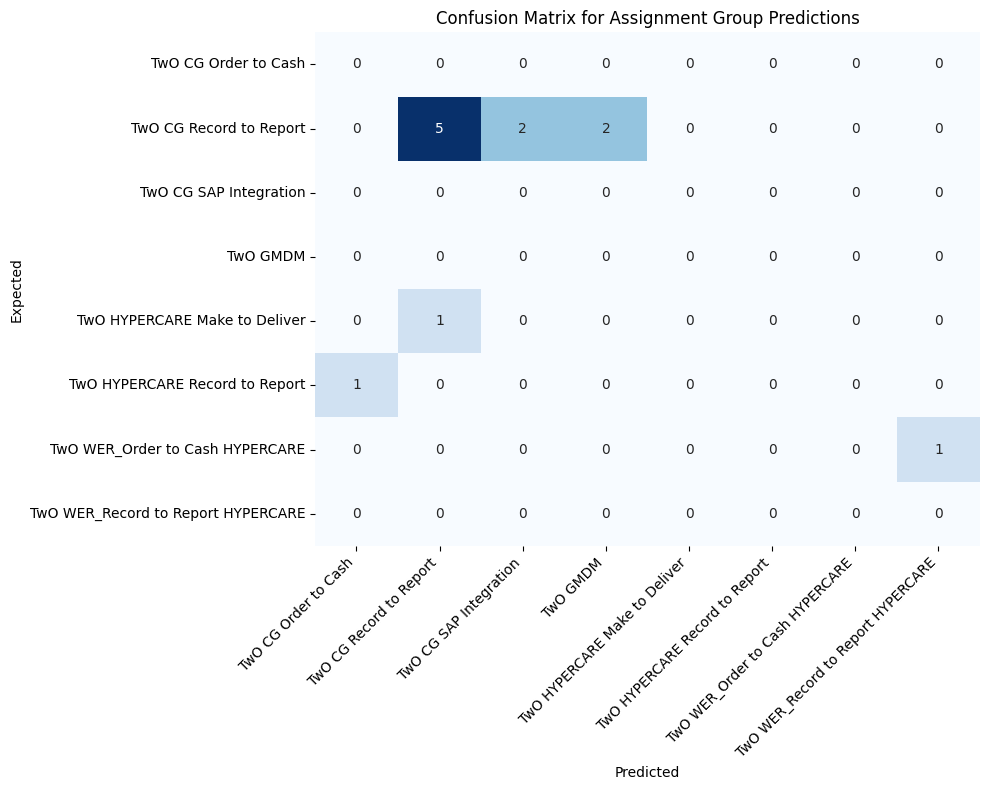

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

data = results
# Extract expected and predicted assignment groups
y_true = [item['expected']['assignment_group'] for item in data]
y_pred = [item['predicted']['assignment_group'] for item in data]

# Get unique labels for the confusion matrix
labels = sorted(set(y_true + y_pred))

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=labels)

# Create a DataFrame for better visualization
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

print("Category: \"Record to Report\"")
print("Subcategory: \"CO\" and \"FI\"")
print("Assignment Groups:", labels)
# Plot confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix for Assignment Group Predictions')
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

# Save the plot
plt.savefig('confusion_matrix.png')
plt.show()